# Sampling from SVG VAE

This is a quick notebook I ([Allison Parrish](http://www.decontextualize.com/) made in order to sample glyphs from [SVG VAE](https://magenta.tensorflow.org/svg-vae), a generative model for scalable vector graphics programmed and trained by [Rapha Gontijo Lopes](https://raphagl.com/). ([Read the paper](https://arxiv.org/abs/1904.02632).)

The code is largely based on [the example notebook](https://github.com/magenta/magenta-demos/blob/master/colab-notebooks/vae_svg_decoding.ipynb) included in the Magenta repository, with a few tweaks I made in order to make the code and content compatible with the tutorials in a class I'm teaching at [NYU ITP]() called [Material of Language](https://github.com/aparrish/material-of-language/).

In this notebook, I'm only demonstrating the model's ability to generate "fonts" (i.e., sets of glyphs), and to generate interpolations between different fonts. My goal was to make it possible for someone without a lot of knowledge about programming or machine learning to step through the notebook, play around with the code a bit, and produce something interesting.

This is a Google Colab notebook. I don't usually like using Google Colab, but I also don't want to have to help all of my students install all of the finicky dependencies on their own computers. So here we are.

> Note for my students: Colab notebooks don't run on your own computer—they run on a computer that Google provides to you for free for a few hours. If the notebook is inactive for a while, the system deletes the machine—and your work. The notebook file itself is saved to Google Drive, but any files that you save will be deleted when the machine is recycled. Also note that you'll need to *redownload data and re-install packages* whenever you open the notebook (if the machine has timed out since the last time you used it). 

For a quick explanation of how the model works and its architecture, I recommend reading [the clear and concise blog post](https://magenta.tensorflow.org/svg-vae) that the authors wrote about the model for Magenta.

## Download the model and associated data

Before we get started programming, we need to download the pre-trained model. The authors made this available online; run the cell below to download it:

In [ ]:
!curl -L -O https://storage.googleapis.com/magentadata/models/svg_vae/svg_vae.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  776M  100  776M    0     0   208M      0  0:00:03  0:00:03 --:--:--  208M


The models are stored in a gzipped tar file—uncompress it by running the cell below:

In [ ]:
!tar xvfz svg_vae.tar.gz

usr/local/google/home/iraphael/dev/svg_vae/
usr/local/google/home/iraphael/dev/svg_vae/svg_decoder_internal/
usr/local/google/home/iraphael/dev/svg_vae/svg_decoder_internal/model.ckpt-300000.data-00000-of-00002
usr/local/google/home/iraphael/dev/svg_vae/svg_decoder_internal/checkpoint
usr/local/google/home/iraphael/dev/svg_vae/svg_decoder_internal/model.ckpt-300000.data-00001-of-00002
usr/local/google/home/iraphael/dev/svg_vae/svg_decoder_internal/model.ckpt-300000.meta
usr/local/google/home/iraphael/dev/svg_vae/svg_decoder_internal/model.ckpt-300000.index
usr/local/google/home/iraphael/dev/svg_vae/image_vae_internal/
usr/local/google/home/iraphael/dev/svg_vae/image_vae_internal/model.ckpt-100000.meta
usr/local/google/home/iraphael/dev/svg_vae/image_vae_internal/model.ckpt-100000.data-00000-of-00002
usr/local/google/home/iraphael/dev/svg_vae/image_vae_internal/model.ckpt-100000.data-00001-of-00002
usr/local/google/home/iraphael/dev/svg_vae/image_vae_internal/checkpoint
usr/local/google

You'll also need the following two files, which are used to "un-normalize" the SVG paths that come out of the model. (Thanks to Rapha for giving me access to these files!)

In [ ]:
!curl -L -O https://github.com/aparrish/material-of-language/raw/master/svg_vae_data/mean.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   158  100   158    0     0   1112      0 --:--:-- --:--:-- --:--:--  1112
100   160  100   160    0     0    462      0 --:--:-- --:--:-- --:--:--  156k


In [ ]:
!curl -L -O https://github.com/aparrish/material-of-language/raw/master/svg_vae_data/stdev.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    987      0 --:--:-- --:--:-- --:--:--   987
100   160  100   160    0     0    500      0 --:--:-- --:--:-- --:--:--   500


## Dependencies

We need the `tensor2tensor` library and the `magenta` library. Hopefully both of these will install without trouble in Colab:

In [ ]:
!pip install tensor2tensor==1.14.1

     |████████████████████████████████| 1.6MB 4.2MB/s 
     |████████████████████████████████| 5.3MB 41.8MB/s 
     |████████████████████████████████| 655kB 53.9MB/s 
     |████████████████████████████████| 194kB 54.1MB/s 
     |████████████████████████████████| 368kB 51.5MB/s 
     |████████████████████████████████| 983kB 52.8MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 368kB 54.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 245kB 54.2MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67161 sha256=fd9948ab39cda1a52de064345e36dd14735bf2701b61c55f71d27e703c656e3f
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
  Created wheel for bz2file: filename=bz2file-0.98-cp36-none-any.whl size=6883 sha256=1e99dfab11f83899e86efc08d69c6693318355e7ae5c26ec61d6d83ec955a985
  Stored in directory: /root/.cache/p

In [ ]:
!pip install magenta==1.3.2

     |████████████████████████████████| 1.6MB 4.3MB/s 
     |████████████████████████████████| 1.6MB 44.9MB/s 
     |████████████████████████████████| 110.5MB 48kB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 2.3MB 46.1MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
     |████████████████████████████████| 204kB 40.3MB/s 
     |████████████████████████████████| 8.9MB 28.9MB/s 
     |████████████████████████████████| 5.6MB 40.8MB/s 
     |████████████████████████████████| 655kB 34.4MB/s 
     |████████████████████████████████| 512kB 43.7MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 3.8MB 55.5MB/s 
     |████████████████████████████████| 153kB 31.6MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 63.8MB 66kB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 2.0MB 49.5MB/s 
   

We also need Flat and Bezmerizing so we can draw the SVG commands that come out of the model. (There are other ways to do this, of course, but I like having the flexibility of Flat and Bezmerizing.)

In [ ]:
!pip install flat

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for flat: filename=Flat-0.3.2-cp36-none-any.whl size=54606 sha256=6431a15984c1cc6f31ea593fe5b26b124953c6d5dcedb7eaca45810d2d795a17
  Stored in directory: /root/.cache/pip/wheels/93/d3/ab/244d1137dafd93cafe471e0f20c4e26d115fa65bdc81e9a99d
Successfully built flat


In [ ]:
!pip install https://github.com/aparrish/bezmerizing/archive/master.zip

     | 317kB 2.7MB/s
  Created wheel for bezmerizing: filename=bezmerizing-0.1.0-cp36-none-any.whl size=15816 sha256=12541f57de43b17733613a3960645725abef8ba9334c9290b05da6e9dc3ef1b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-x96t1mo_/wheels/93/43/9b/8acebe44e4ac5fc93427a03a09bd7cd8110979c5701c77c7f8
Successfully built bezmerizing


## Code preliminaries

The following cell makes available various libraries that the rest of the code needs to function, including the Flat and Bezmerizing libraries that we'll use to draw the paths generated by the model.

In [ ]:
from __future__ import print_function

import copy
import logging
import numpy as np
import re
import tensorflow as tf
import warnings

from tensor2tensor.utils import registry
from magenta.models import svg_vae
from magenta.models.svg_vae import svg_utils
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib

# for drawing the paths
from flat import document, shape, rgb, svg
from bezmerizing import Path

tfe = tf.contrib.eager
Modes = tf.estimator.ModeKeys

tf.enable_eager_execution()
tf.get_logger().setLevel('WARN')

logging.getLogger("mlperf_compliance").setLevel(logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import SVG, display
def show(page):
    display(SVG(page.svg()))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







This function loads and returns the pre-trained model from disk:

In [ ]:
def initialize_model_svg(problem_name, hparam_set, hparams, model_name,
                     ckpt_dir, split=Modes.TRAIN):
  """Returns an initialized model, dataset iterator and hparams."""
  tf.reset_default_graph()
  
  # create hparams and get glyphazzn problem definition
  hparams = trainer_lib.create_hparams(hparam_set, hparams,
                                       problem_name=problem_name)
  problem = registry.problem(problem_name)
  
  # get model definition
  ModelClass = registry.model(model_name)
  model = ModelClass(hparams, mode=Modes.PREDICT,
                     problem_hparams=hparams.problem_hparams)
  
  # the model apparently needs to be "fed" a sample before you can
  # initialize it from the checkpoint. as far as I can tell, it
  # doesn't matter what's in this sample—it can be completely made up.
  # I'm not sure if I got these dimensions right, not sure if it matters?
  features = {}
  features['bottleneck'] = tf.random_normal([64, 32])
  features['targets_cls'] = [[11]*64]
  features['inputs'] = tf.zeros([64, 51, 1, hparams.problem.feature_dim])
  features['targets_psr'] = tf.zeros([64, 1, 64*64, 1])
  features['targets'] = tf.zeros([64, 51, 1, hparams.problem.feature_dim])
  output, extra_losses = model(features)
  model.initialize_from_ckpt(ckpt_dir)  # initializes ops
  
  return model, hparams

... and this function loads and returns the numpy arrays that we need in order to un-normalize the paths:

In [ ]:
def get_means_stdevs():
  with tf.gfile.Open('mean.npz', 'rb') as f:
    mean_npz = np.load(f)
  with tf.gfile.Open('stdev.npz', 'rb') as f:
    stdev_npz = np.load(f)
  return mean_npz, stdev_npz

## Generating glyphs from the model

Okay, with all that out of the way, we can actually get around to generating stuff with the model. First, load the model like so:

In [ ]:
svg_model, svg_hparams = initialize_model_svg(
    problem_name='glyph_azzn_problem',
    hparam_set='svg_decoder',
    hparams=(
        "vae_ckpt_dir=usr/local/google/home/iraphael/dev/svg_vae/image_vae_external/,"
        "vae_hparam_set=image_vae,mix_temperature=0.0001,gauss_temperature=0.0001"
    ),
    model_name='svg_decoder',
    ckpt_dir='usr/local/google/home/iraphael/dev/svg_vae/svg_decoder_external/')






Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.
Instructions for updating:
Use 

We want to use the model to generate SVG paths for letterforms. To do this, you call the model's `.infer()` method, with a vector as a parameter. The model "decompresses" this vector into a sequence of SVG commands. Because this is a generative model, you can pass in arbitrary numbers for this vector—even random numbers (using a normal distribution). SVG paths generated from similar vectors will have similar characteristics.

The function in the cell below calls the model's `.infer()` method with the specified vector. (This vector should have 32 dimensions, which is the size of the model's latent variable. It'll work best with a number that is sampled from a normal distribution.) It generates one vector for every letter in the model's vocabulary (0-9, A-Z, a-z).

In [ ]:
def infer_alphabet(z):
    batch_size = 62 # total number of classes
    # dimensions of pretrained model's latent space (I just happen to know this)
    zdim = 32
    # using the same z value for each letter in the alphabet
    bottleneck = tf.tile([z.astype(np.float32)], [batch_size, 1])
    # the .infer() method requires an "example" sample from the dataset.
    # here I just create a dummy record. the only important values are
    # `bottleneck` (the value for the latent space) and `targets_cls` (the
    # classes that we want to generate)
    features = {}
    features['bottleneck'] = bottleneck
    features['targets_cls'] = [i for i in range(batch_size)]
    features['inputs'] = tf.zeros([batch_size, 51, 1,
                                   svg_hparams.problem.feature_dim])
    features['targets'] = tf.zeros([batch_size, 51, 1,
                                    svg_hparams.problem.feature_dim])
    features['targets_psr'] = tf.zeros([batch_size, 1, 64*64, 1])
    out = svg_model.infer(features, decode_length=0)
    return out['outputs']

Run the function like so. (The `np.random.randn()` function generates a random vector with the specified number of dimensions following a normal distribution.)

In [ ]:
alphabet = infer_alphabet(np.random.randn(32))

The resulting value is a big old weird tensor that isn't very valuable to us on its own. ("Tensor" btw is essentially a fancy word for "a list with other lists in it, and those lists might have other lists in them to, and so forth.") But each row contains an encoded version of an SVG command. There's one row for each letter in the model's vocabulary.

In [ ]:
alphabet

<tf.Tensor: id=38537, shape=(62, 51, 1, 10), dtype=float32, numpy=
array([[[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          -8.15776408e-01,  3.48037744e+00,  2.00797081e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.25268660e-03,  3.82593304e-01,  1.34162813e-01]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           6.86088443e-01,  3.00547868e-01,  4.57475066e-01]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
           1.98796034e+00, -1.06533587e+00, -7.39797652e-01]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           6.47826612e-01,  3.71562779e-01, -8.01553249e+00]],

        [[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.30216968e+00,  7.50010252e-01, -3.51988018e-01]]],


       [[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          -1.27556336e+00,  3.78397775e+00,  1.82501996e+00]],

       

To display the character generated by the model, we need to convert that encoded value to an actual SVG command. Even more useful to us would be a Bezmerizing `Path` object, which we can use to draw the glyph to the screen using Flat.

The function below takes the tensor returned from `infer_alphabet()` and returns a list of `Path` objects for each row in the tensor. (This function makes use of various functions that are distributed with the source code of the model in its `svg_utils` module.)

In [ ]:
def tensor_to_paths(out):
    mean_npz, stdev_npz = get_means_stdevs()
    all_paths = []
    for i in range(out.shape[0]):
        tensor = tf.expand_dims(out[i], 0)
        # "unnormalize" the tensor (using values calculated from the
        # pre-processed data set)
        tensor = (tensor * stdev_npz) + mean_npz
        vector = tf.squeeze(svg_utils.make_simple_cmds_long(tensor), [0, 2])
        path_parts = []
        # convert each row in this vector to an SVG command
        for vec in vector:
            cmd = svg_utils.vector_to_cmd(vec, categorical=True,
                                          return_floats=True)
            # if this is the end of the string, break out of the loop
            is_eos = np.argmax(vec[:20]) == 0
            if is_eos:
                break
            if len(cmd) > 0:
                cmd_formatted = cmd[0] + ' ' + ' '.join(
                    [f'{c:.5f}' for c in cmd[1:]])
                path_parts.append(cmd_formatted)
        path_str = ' '.join(path_parts)
        path = Path(svg.parsepath(path_str.encode('utf8')))
        all_paths.append(path)
    return all_paths

Finally, the `generate_alphabet()` function combines these two, returning the paths for an alphabet generated from a single vector:

In [ ]:
def generate_alphabet(z):
    return tensor_to_paths(infer_alphabet(z))

So now we can easily generate an entire alphabet of paths:

In [ ]:
alphabet_paths = generate_alphabet(np.random.randn(32))

Take a look at one of the paths:

In [ ]:
alphabet_paths[0]

Path([moveto(x=13.1396, y=6.7650), curveto(x1=16.9727, y1=6.7670, x2=15.9311, y2=6.7663, x=18.4446, y=7.8789), lineto(x=17.6192, y=11.9817), curveto(x1=16.5133, y1=13.8650, x2=16.3467, y2=13.3876, x=15.7472, y=15.2153), curveto(x1=15.1342, y1=17.0357, x2=15.1064, y2=17.0793, x=14.8630, y=18.5835), curveto(x1=14.4258, y1=20.3964, x2=14.6274, y2=20.0237, x=12.6456, y=20.8036), curveto(x1=11.0455, y1=21.4517, x2=11.0115, y2=21.4136, x=8.9615, y=21.4069), curveto(x1=6.7730, y1=21.4070, x2=7.0814, y2=21.4041, x=5.0738, y=20.2582), curveto(x1=3.2646, y1=19.0665, x2=3.2273, y2=19.0412, x=3.0867, y=18.0894), curveto(x1=3.0085, y1=16.7855, x2=3.0300, y2=16.5446, x=3.2137, y=15.4478), curveto(x1=3.4077, y1=14.3127, x2=3.4062, y2=14.3074, x=3.7429, y=13.1878), curveto(x1=4.0717, y1=12.0592, x2=4.0696, y2=12.0543, x=4.5119, y=11.0605), curveto(x1=4.9520, y1=10.0840, x2=4.9498, y2=10.0814, x=5.5434, y=9.2520), curveto(x1=6.6421, y1=8.4220, x2=6.7340, y2=8.4160, x=6.9757, y=7.8667), curveto(x1=7.230

The `generate_alphabet()` function returns a list of paths. In this list, the index for a particular character corresponds to that character's position in the sequence of values 0-9, A-Z, a-z. The function below takes a character and returns its position in this sequence (if applicable):


In [ ]:
def c2i(ch):
    lookup = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    return lookup.index(ch)

In [ ]:
def i2c(i):
    lookup = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    return lookup[i]

For example, the index of the capital letter `P`:

In [ ]:
c2i('P')

25

The following cell puts all of this together, and draws the glyph in this generated alphabet for the letter `P`.

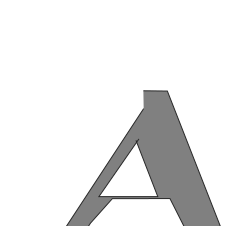

In [ ]:
glyph = alphabet_paths[c2i('A')]
page = document(80, 80, 'mm').addpage()
pen = shape().stroke(rgb(40, 40, 40)).fill(rgb(128, 128, 128))
page.place(pen.path(glyph.scale(4)))

#page.svg("A.svg")
show(page)

The following example draws all 62 glyphs in the alphabet in a grid, so you can preview the results. (Each time you run the cell, it will generate a new alphabet.)

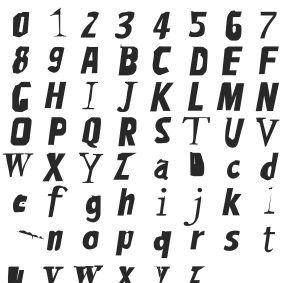

In [ ]:
alphabet_paths = generate_alphabet(np.random.randn(32))
width = 100
height = 100
page = document(width, height, 'mm').addpage()
pen = shape().nostroke().fill(rgb(40, 40, 40))
grid_size = 8
cell_size = width / grid_size
for i in range(grid_size):
    for j in range(grid_size):
        x = i * cell_size
        y = j * cell_size
        idx = (j * grid_size) + (i % grid_size)
        if idx < len(alphabet_paths):
            this_glyph = alphabet_paths[idx]
            page.place(pen.path(this_glyph.scale(0.6).translate(x, y)))
show(page)

alphabet_1/0.svg


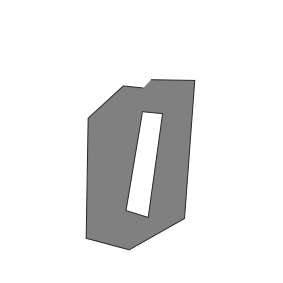

alphabet_1/1.svg


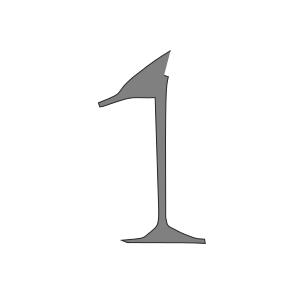

alphabet_1/2.svg


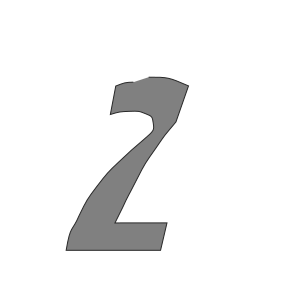

alphabet_1/3.svg


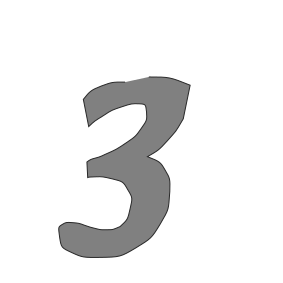

alphabet_1/4.svg


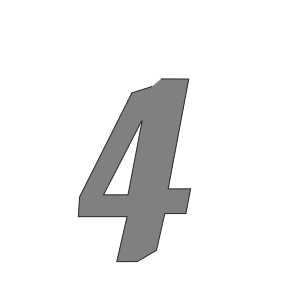

alphabet_1/5.svg


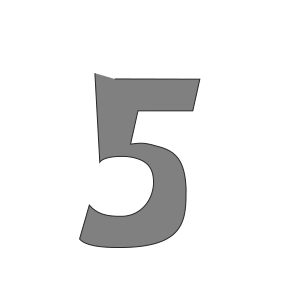

alphabet_1/6.svg


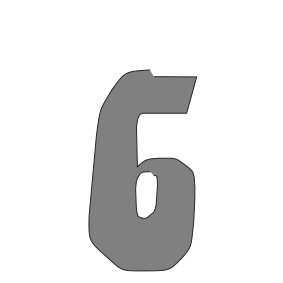

alphabet_1/7.svg


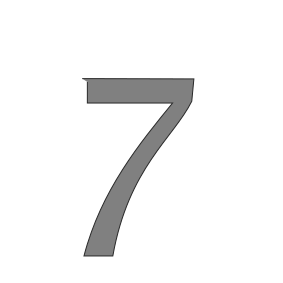

alphabet_1/8.svg


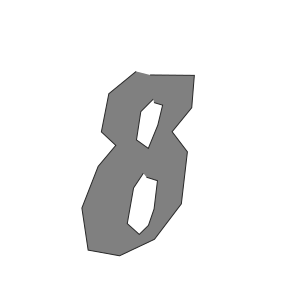

alphabet_1/9.svg


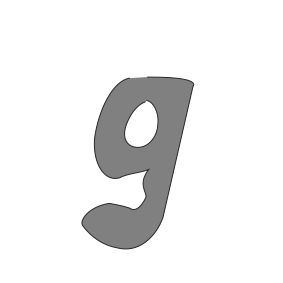

alphabet_1/10.svg


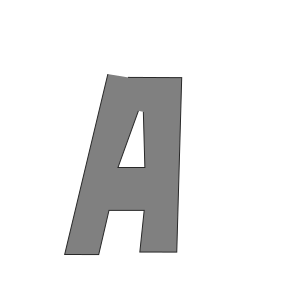

alphabet_1/11.svg


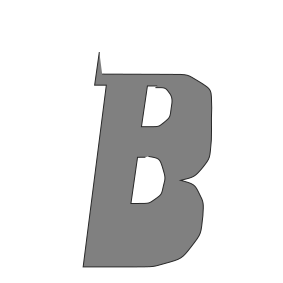

alphabet_1/12.svg


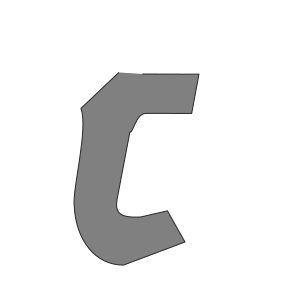

alphabet_1/13.svg


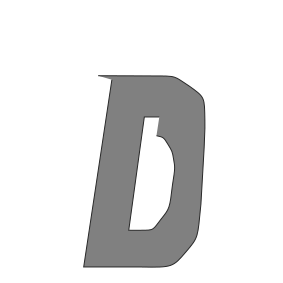

alphabet_1/14.svg


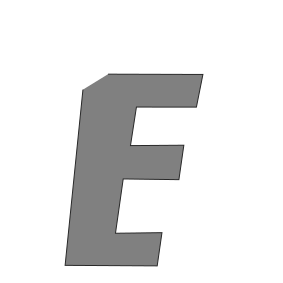

alphabet_1/15.svg


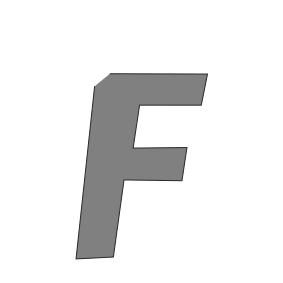

alphabet_1/16.svg


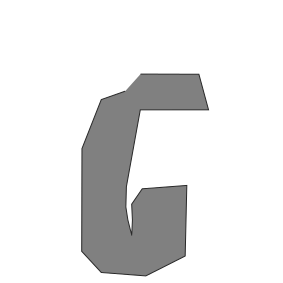

alphabet_1/17.svg


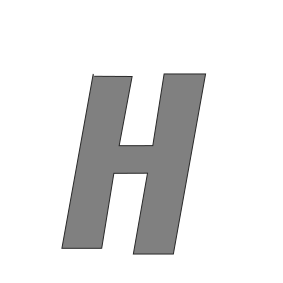

alphabet_1/18.svg


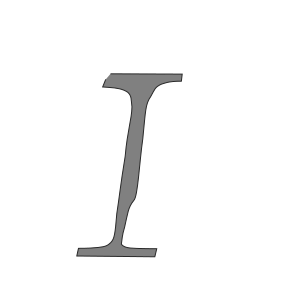

alphabet_1/19.svg


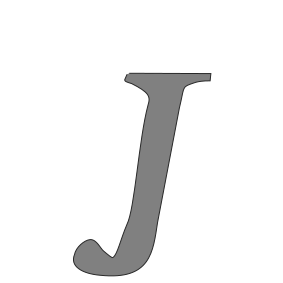

alphabet_1/20.svg


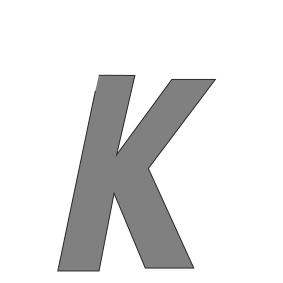

alphabet_1/21.svg


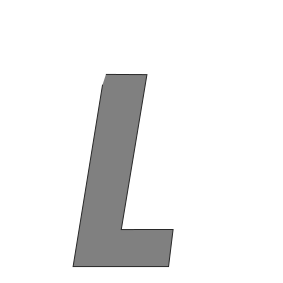

alphabet_1/22.svg


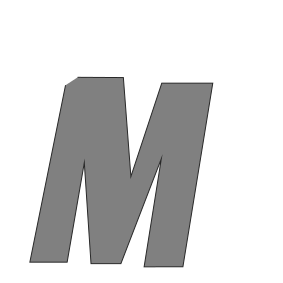

alphabet_1/23.svg


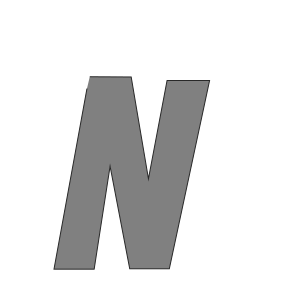

alphabet_1/24.svg


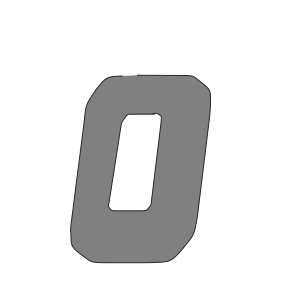

alphabet_1/25.svg


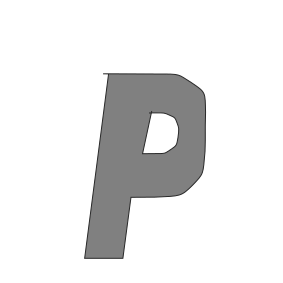

alphabet_1/26.svg


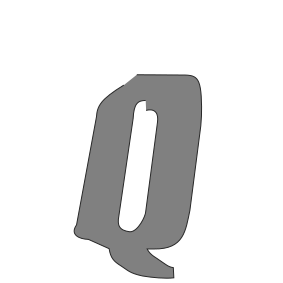

alphabet_1/27.svg


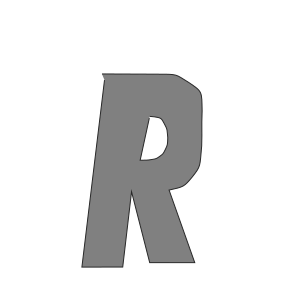

alphabet_1/28.svg


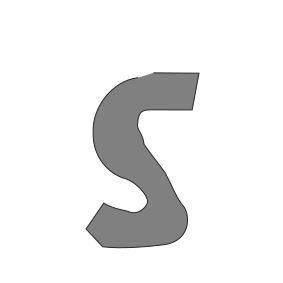

alphabet_1/29.svg


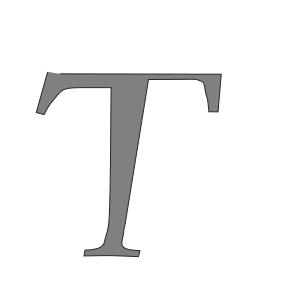

alphabet_1/30.svg


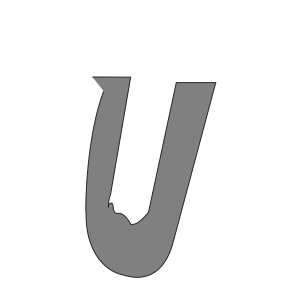

alphabet_1/31.svg


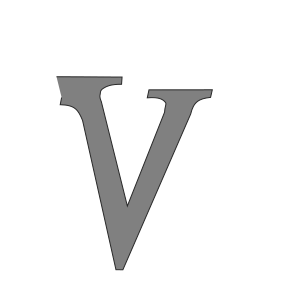

alphabet_1/32.svg


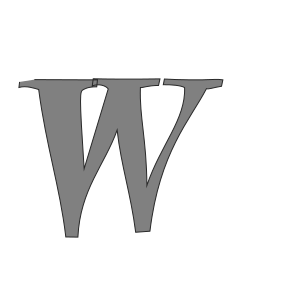

alphabet_1/33.svg


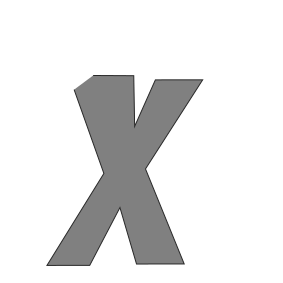

alphabet_1/34.svg


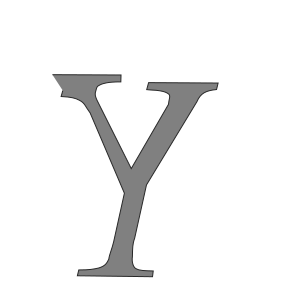

alphabet_1/35.svg


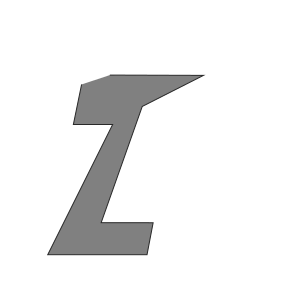

alphabet_1/36.svg


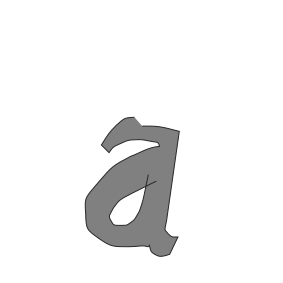

alphabet_1/37.svg


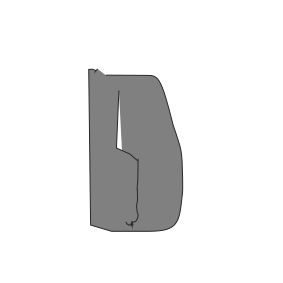

alphabet_1/38.svg


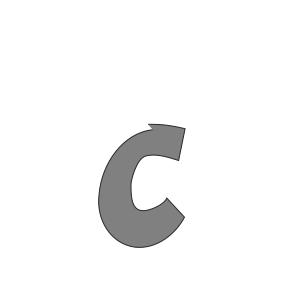

alphabet_1/39.svg


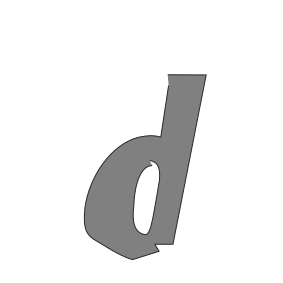

alphabet_1/40.svg


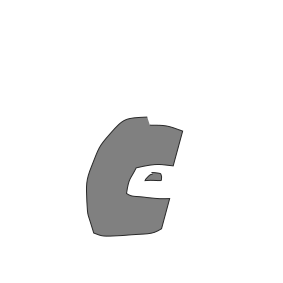

alphabet_1/41.svg


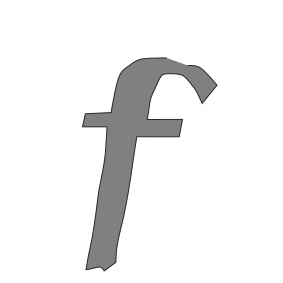

alphabet_1/42.svg


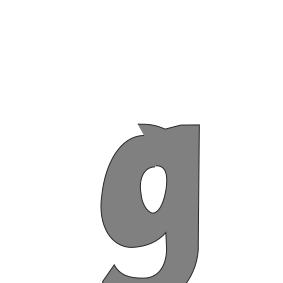

alphabet_1/43.svg


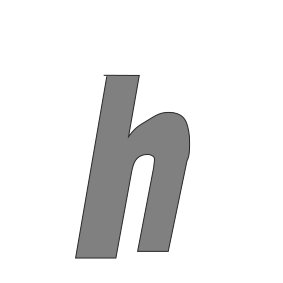

alphabet_1/44.svg


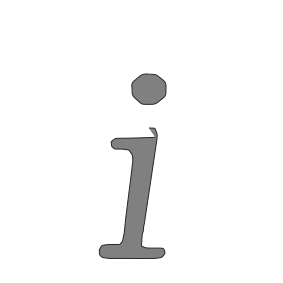

alphabet_1/45.svg


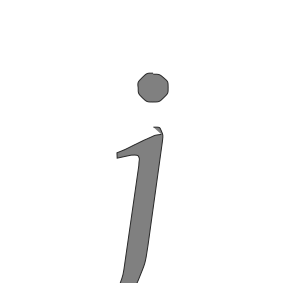

alphabet_1/46.svg


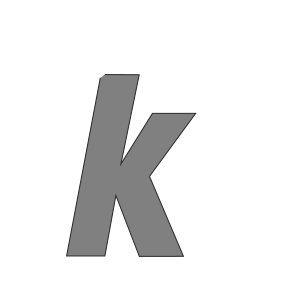

alphabet_1/47.svg


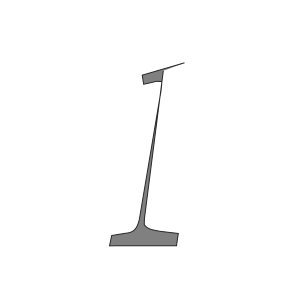

alphabet_1/48.svg


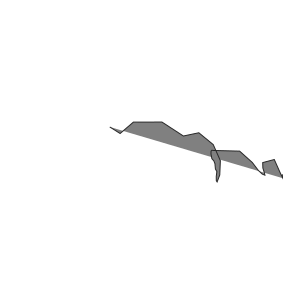

alphabet_1/49.svg


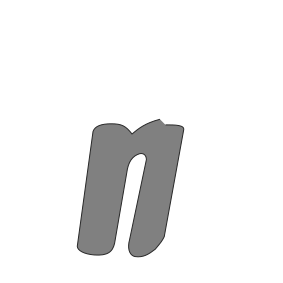

alphabet_1/50.svg


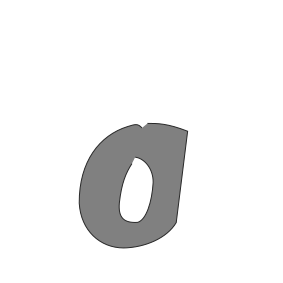

alphabet_1/51.svg


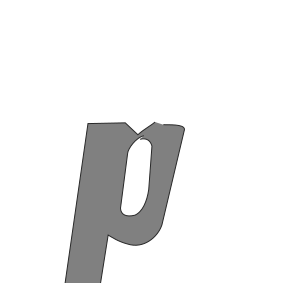

alphabet_1/52.svg


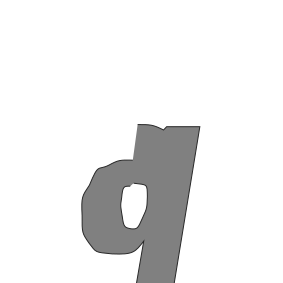

alphabet_1/53.svg


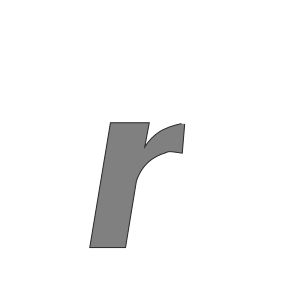

alphabet_1/54.svg


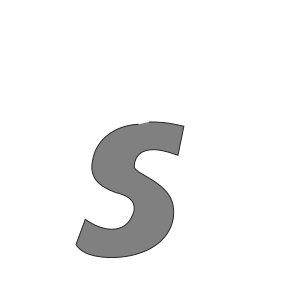

alphabet_1/55.svg


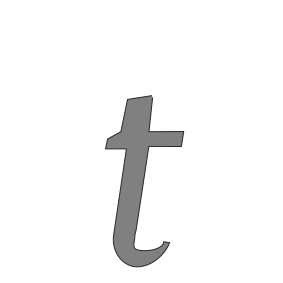

alphabet_1/56.svg


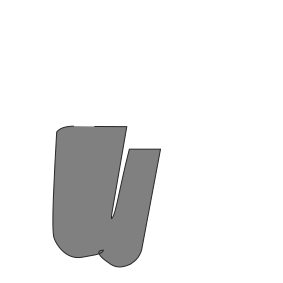

alphabet_1/57.svg


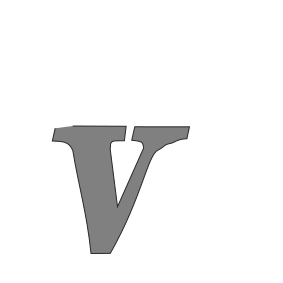

alphabet_1/58.svg


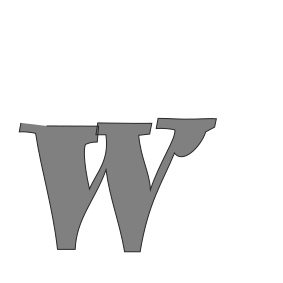

alphabet_1/59.svg


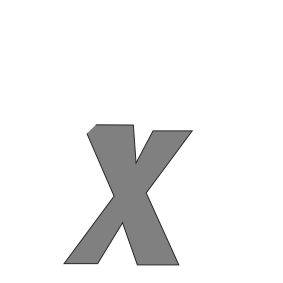

alphabet_1/60.svg


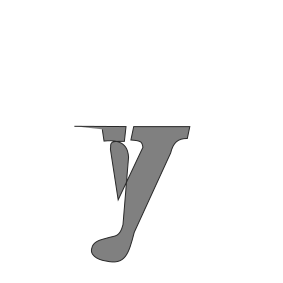

alphabet_1/61.svg


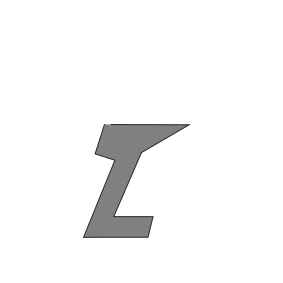

In [ ]:
for i in range(len(alphabet_paths)):
  glyph = alphabet_paths[i]
  page = document(100, 100, 'mm').addpage()
  pen = shape().stroke(rgb(40, 40, 40)).fill(rgb(128, 128, 128))
  page.place(pen.path(glyph.scale(4)))

  #file_name = 'alphabet/' + i2c(i) + '.svg'
  file_name = 'alphabet_1/' + str(i) + '.svg'
  print(file_name)
  show(page)
  page.svg(file_name)

In [ ]:
from google.colab import files

!zip -r /content/alphabet_1.zip /content/alphabet_1
#files.download("/content/alphabet.zip")

updating: content/alphabet_1/ (stored 0%)
updating: content/alphabet_1/10.svg (deflated 38%)
updating: content/alphabet_1/26.svg (deflated 43%)
updating: content/alphabet_1/20.svg (deflated 36%)
updating: content/alphabet_1/5.svg (deflated 40%)
updating: content/alphabet_1/24.svg (deflated 45%)
updating: content/alphabet_1/47.svg (deflated 39%)
updating: content/alphabet_1/3.svg (deflated 47%)
updating: content/alphabet_1/52.svg (deflated 43%)
updating: content/alphabet_1/18.svg (deflated 43%)
updating: content/alphabet_1/36.svg (deflated 46%)
updating: content/alphabet_1/57.svg (deflated 43%)
updating: content/alphabet_1/14.svg (deflated 37%)
updating: content/alphabet_1/41.svg (deflated 42%)
updating: content/alphabet_1/7.svg (deflated 37%)
updating: content/alphabet_1/17.svg (deflated 37%)
updating: content/alphabet_1/49.svg (deflated 42%)
updating: content/alphabet_1/33.svg (deflated 37%)
updating: content/alphabet_1/61.svg (deflated 37%)
updating: content/alphabet_1/4.svg (deflate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Typesetting with SVG-VAE glyphs

Now we can draw single glyphs to the screen, which is fantastic! If we want to actually typeset some text, it's a bit more tricky. The model doesn't tell us each character's advance, so we'll have to guess! The characters are also generated in the middle of their canvas, so we need to correct for the fact that some narrow characters (like, say, `i`) will need to have their path data shifted over in order to get rid of empty space on the left hand side of the character.

For simplicity's sake in this section, I'm going to focus on setting *single lines* of text.

First, an example string:

In [ ]:
s = "456 Quartzy Foxes"

And then we'll generate an alphabet:

In [ ]:
alpha = generate_alphabet(np.random.randn(32))

The function below calculates the minimum and maximum x-coordinates of every command in the path. This gives us both the amount we need to shift the glyph in order to eliminate empty space to the left of the glyph, and how far we need to advance the cursor after drawing the glyph:

In [ ]:
def x_extent(path):
    all_x = [getattr(cmd, 'x', 0) for cmd in path.commands]
    return min(all_x), max(all_x)

If this works, we should be able to draw a rectangle around a character. Let's try it out:

In [ ]:
ch = 'j'
min_x, max_x = x_extent(alpha[c2i(ch)])
page = document(32, 32, 'mm').addpage()
rect_pen = shape().stroke(rgb(0, 255, 0)).nofill()
letter_pen = shape().nostroke().fill(rgb(40, 40, 40))
page.place(rect_pen.rectangle(min_x, 0, max_x - min_x, 32))
page.place(letter_pen.path(alpha[c2i(ch)]))
show(page)

Working from the example code in the [manipulating font data notebook](https://github.com/aparrish/material-of-language/blob/master/manipulating-font-data.ipynb), we now have everything we need to typeset a single line of text. I've commented the source code below:

In [ ]:
page = document(300, 50, 'mm').addpage()
pen = shape().nostroke().fill(rgb(40, 40, 40))
cx = 0 # current "cursor" position
kern = 1 # to modify spacing between characters
for ch in s:
    # if it's a space, just advance
    if ch == ' ':
        advance = 5 # maybe?
    # otherwise...
    else:
        glyph_path = alpha[c2i(ch)] # get path for this character
        min_x, max_x = x_extent(glyph_path) # find min/max x values
        advance = max_x - min_x # amount to move forward
        # shift glyph to the left to eliminate empty space, then
        # add the current cursor value
        glyph_path = glyph_path.translate(-min_x + cx, 0)
        page.place(pen.path(glyph_path))
    cx += advance + kern
show(page)

For some of the code below, it'll be helpful to typeset text into a larger `Path` object, instead of placing it on the page directly. (This will make it easier to move the typeset text around on the page.) The following function has largely the same logic as the code above, but returns a composite `Path` with all of the characters in the given string at their correct positions:

In [ ]:
from itertools import chain
def combine_path(alpha, s, kern=0):
    text_paths = []
    cx = 0
    for ch in s:
        if ch == ' ':
            advance = 5
        else:
            glyph_path = alpha[c2i(ch)]
            min_x, max_x = x_extent(glyph_path)
            advance = max_x - min_x
            glyph_path = glyph_path.translate(-min_x + cx, 0)
            text_paths.append(glyph_path)
        cx += advance + kern
    combined = Path(list(chain(*text_paths)))
    return combined

A quick demo to make sure it works. (Rotated so that you can see that rotation affects the entire string, not individual characters.)

In [ ]:
string_path = combine_path(alpha, s)
page = document(300, 50, 'mm').addpage()
pen = shape().nostroke().fill(rgb(40, 40, 40))
page.place(pen.path(string_path.rotate(-np.pi / 12)))
show(page)

## Interpolating between alphabets

Generative models have an interesting property, which is that outputs generated from similar latent variables produce similar outputs. With the SVG-VAE, this property makes it possible to generate two different alphabets and then *interpolate* between them by generating alphabets from points along the line that connects the original two values.

It might be easier to reason about how interpolation works if we start with single values, instead of vectors. For example, the following bit of code uses numpy's `linspace()` function to generate a list of values that starts at `0` and goes to `100`, with seven stops along the way:

In [ ]:
np.linspace(0, 100, 7)

array([  0.        ,  16.66666667,  33.33333333,  50.        ,
        66.66666667,  83.33333333, 100.        ])

The function will also generate values along the line that connects two 2D points:

In [ ]:
np.linspace([0, 10], [30, 80], 13)

array([[ 0.        , 10.        ],
       [ 2.5       , 15.83333333],
       [ 5.        , 21.66666667],
       [ 7.5       , 27.5       ],
       [10.        , 33.33333333],
       [12.5       , 39.16666667],
       [15.        , 45.        ],
       [17.5       , 50.83333333],
       [20.        , 56.66666667],
       [22.5       , 62.5       ],
       [25.        , 68.33333333],
       [27.5       , 74.16666667],
       [30.        , 80.        ]])

You can use the same function to generate points along the line that connects vectors with a larger number of dimensions. In the cell below, I generate two random vectors, and then use `linspace()` to calculate values between them:

In [ ]:
start = np.random.randn(32)
stop = np.random.randn(32)
latents = np.linspace(start, stop, 8)

The code in the cell below generates alphabets from each of these values. It takes a while to run! You'll notice that—while the first and last samples are very different—each line is similar in the style to the one that follows it. Seen together, it seems as though the first sample is "smoothly transitioning" to the final sample.

In [ ]:
page = document(240, 160, 'mm').addpage()
pen = shape().nostroke().fill(rgb(40, 40, 40))
cy = 0
for i, vec in enumerate(latents):
    print(i, end=" ") # print progress, since this takes a while
    alpha = generate_alphabet(vec)
    string_path = combine_path(alpha, "abcdefghijklmnopqrstuvwxyz", kern=2)
    page.place(pen.path(string_path.scale(0.8).translate(0, cy)))
    cy += 19 # just eyeballed this value, adjust to taste
show(page)

0 1 2 3 4 5 6 7 